In [48]:
import datetime
import numpy as np
import pandas as pd
# import seaborn as sns
from dateutil.relativedelta import relativedelta
# from sklearn.metrics import roc_curve, auc, f1_score, mean_squared_error
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import train_test_split, KFold
# from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
import keras_metrics as km
# 在metrics中计算f1 score


print('Pandas',pd.__version__)
print('NumPy',np.__version__)
print('TensorFlow',tf.__version__)

Pandas 1.3.4
NumPy 1.19.5
TensorFlow 2.6.0


In [49]:
# 示例中出现但暂时没用到的
# import os, time, sys
# from collections import Counter
# from functools import reduce

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

# import matplotlib
# import random

# 读取数据

In [50]:
# Read data
userinfo_train = pd.read_csv('./userinfo.csv')
bank_train = pd.read_csv('./bank.csv')
bill_train = pd.read_csv('./bill.csv')
overdue_train = pd.read_csv('./overdue.csv')

df_dict = {"用户信息": userinfo_train,
"银行流水": bank_train,
"账单": bill_train,
"违约记录": overdue_train}

In [51]:
# Show info
# for name in df_dict:
    # print(name+":", len(df_dict[name]), "行")
    # display(df_dict[name].head())
    
# show whether a table contains null value
for name in df_dict:
    print("%s:%s" %(name, np.any(df_dict[name].isnull())))
    
# Show specific info of null value table 
for name in df_dict:
    df = df_dict[name]
    if np.any(df.isnull()):
        print("%s存在空值" %name)
        print(df.isnull().sum(axis=0))
        display(df[df.isnull().any(axis=1)])
        print("存在 %d 行空值" %len(df[df.isnull().any(axis=1)]))

        # Drop null record
        df_dict[name] = df[~df.isnull().any(axis=1)]
        print("%s已更新" %name)

用户信息:True
银行流水:False
账单:False
违约记录:False
用户信息存在空值
new_user_id    0
性别             0
职业             2
教育程度           0
婚姻状态           1
户口类型           0
dtype: int64


,new_user_id,性别,职业,教育程度,婚姻状态,户口类型
31,3be79a55ccf09062cdff1b9c684179f9,男,NaN,本科及以上,离异,农业户口
135,b074add6f740af33df4230f28d37a333,男,NaN,大专,离异,家庭户口
5345,9f2e0eb314d821f8d075fbc9e64ce4f5,男,公职,高中,NaN,农业户口


存在 3 行空值
用户信息已更新


In [52]:
# 描述性统计
def describe(dataframe, features):
    output = pd.DataFrame(columns=('Variable', 'Count', 'Mean', 'Minimum', 'Median', 'Max', 'Std.Error'))

    for feature in features:
        rec = pd.Series({
            'Variable':feature,
            'Count':int(dataframe[[feature]].count()),
            'Mean':dataframe[feature].mean(),
            'Minimum':dataframe[feature].min(),
            'Median':dataframe[feature].median(),
            'Max':dataframe[feature].max(),
            'Std.Error':dataframe[feature].std()
        })
        output = output.append(rec, ignore_index=True)

    display(output)
    
# df1=df_dict["银行流水"][['交易类型','工资收入标记', '交易年', '交易月', '交易金额']]
# df2=df_dict["账单"][[
#     '银行id',
#     '消费笔数',
#     '还款状态',
#     '账单年',
#     '账单月',

#     '上期账单金额',
#     '上期还款金额',
#     '信用卡额度',
#     '本期账单余额',
#     '本期账单最低还款额',
#     '本期账单金额',
#     '调整金额',
#     '循环利息',
#     '可用金额',
#     '预借现金额度',
#     ]]

# describe(df1, df1.columns)
# describe(df2, df2.columns)

In [53]:
# 加一个要用的标签
def SexMrg(series):
    sex = series['性别']
    marriage = series['婚姻状态']

    if marriage == '未知':
        return '其他'
    
    if sex == '男':
        if marriage == '已婚':
            return '男已婚'
        else:
            return '男单身'
    elif sex == '女':
        if marriage == '已婚':
            return '女已婚'
        else:
            return '女单身'
    else:
        return '其他'

x = df_dict['用户信息'].copy()
x.loc[:, '性别婚姻']= x[['性别','婚姻状态']].apply(SexMrg, axis=1)
df_dict['用户信息'] = x

In [54]:
x = df_dict['银行流水'].copy()
x.loc[:, '交易年月']= df_dict['银行流水']['交易时间'].str[:7]
df_dict['银行流水'] = x

x = df_dict['账单'].copy()
x.loc[:, '账单年月']= df_dict['账单']['账单时间'].str[:7]
df_dict['账单'] = x

# 计算特征

In [55]:
# min-max标准化
def mNormalization(series):
    return (series - np.min(series)) / (np.max(series) - np.min(series))
# Z-score标准化
def zNormalization(series):
    return (series - np.mean(series)) / np.std(series)

norm_mode = 'continue' # continue, minmax, zscore

if norm_mode == 'continue':
    pass
elif norm_mode == 'minmax':
    df_dict['违约记录']['分数'] = df_dict['违约记录'][['分数']].apply(mNormalization)
    df_dict['违约记录']['分数'].plot.hist()
elif norm_mode == 'zscore':
    df_dict['违约记录']['分数'] = df_dict['违约记录'][['分数']].apply(zNormalization)
    # df_dict['违约记录']['分数'].plot.hist()

# 编码

In [56]:
# Generate dictionary of code for a certain table.
def genCode(pdtable, colList):
    # For safety, you must commit a list sured by yourself.

    code_dict = {}

    for col in colList:
        # Show unique value of a column
        colValue = list(pdtable[col].unique())
        print(col, colValue)

        # Enode of column
        dict = {}
        for index in range(len(colValue)):
            dict[colValue[index]] = index

        # Show result
        print("编码：%s\n" %dict)
        
        # Store data
        code_dict[col] = dict
    return code_dict

col_list=list(df_dict['用户信息'])
col_list.remove('new_user_id')
code_dict = genCode(df_dict['用户信息'], col_list)

df_dict['用户信息'] = df_dict['用户信息'].replace(code_dict)

性别 ['女', '男', '未知']
编码：{'女': 0, '男': 1, '未知': 2}

职业 ['公职', '企业', '事业单位', '无业', '学生']
编码：{'公职': 0, '企业': 1, '事业单位': 2, '无业': 3, '学生': 4}

教育程度 ['本科及以上', '大专', '高中', '初中及以下', '未知']
编码：{'本科及以上': 0, '大专': 1, '高中': 2, '初中及以下': 3, '未知': 4}

婚姻状态 ['未婚', '离异', '已婚', '丧偶', '其他情况', '未知']
编码：{'未婚': 0, '离异': 1, '已婚': 2, '丧偶': 3, '其他情况': 4, '未知': 5}

户口类型 ['集体户口', '家庭户口', '农业户口', '其他户口', '未知']
编码：{'集体户口': 0, '家庭户口': 1, '农业户口': 2, '其他户口': 3, '未知': 4}

性别婚姻 ['女单身', '男单身', '男已婚', '其他', '女已婚']
编码：{'女单身': 0, '男单身': 1, '男已婚': 2, '其他': 3, '女已婚': 4}



In [57]:
df = pd.merge(df_dict['用户信息'], df_dict['违约记录'], on='new_user_id', how='left')
df.head()

,new_user_id,性别,职业,教育程度,婚姻状态,户口类型,性别婚姻,标签,分数
0,7259fe272934e0dc348092c37544a445,0,0,0,0,0,0,0,70.260853
1,0c87f6b1f7e0350a35841ba34df9d26a,1,0,0,1,0,1,1,22.963381
2,74c53a62f15cc039864aefc41170f81b,1,0,1,1,1,1,1,33.866533
3,211f56f356fa6ecc6334bb73e52c7b16,1,1,2,1,2,1,0,80.170224
4,07b0d9ac7924424894141b2fecfa0ee0,1,0,0,2,0,2,0,73.980588


# 特征工程 1
职业、教育程度、信用卡数量、工资收入平均值、欠款额平均值。

In [58]:
# 信用卡数量	统计非重复银行id数量
cards_count = df_dict['账单'].groupby("new_user_id")['银行id'].agg([pd.Series.nunique])
cards_count.columns = ['信用卡数量']
cards_count.reset_index(inplace=True)
# cards_count.head()

In [59]:
# 工资收入平均值	银行流水“工资收入标记”为1的“交易金额”平均值
salary_mean = df_dict['银行流水'][df_dict['银行流水']['工资收入标记'] == 1].groupby("new_user_id")['交易金额'].agg(["mean"])
salary_mean.columns = ['工资收入平均值']
salary_mean.reset_index(inplace=True)
# salary_mean.head()

In [60]:
# 欠款金额平均值	账单“欠款金额”平均值
df_dict['账单']["欠款金额"] = df_dict['账单']["上期账单金额"] - df_dict['账单']["上期还款金额"]
debt_mean = df_dict['账单'].groupby("new_user_id")["欠款金额"].agg(["mean"])
debt_mean.columns = ['欠款金额平均值']
debt_mean.reset_index(inplace=True)
# debt_mean.head()

In [61]:
df = pd.merge(df, cards_count, on='new_user_id', how='left')
df = pd.merge(df, salary_mean, on='new_user_id', how='left')
df = pd.merge(df, debt_mean, on='new_user_id', how='left')
df = df.fillna(0)

# 特征工程 2
非工资收入平均值、非工资收入次数月均值、工资占收入比例月均值、支出次数月均值。

In [62]:
# 非工资收入平均值	银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”平均值
nonsalary_mean = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby("new_user_id")['交易金额'].agg(["mean"])
nonsalary_mean.columns = ['非工资收入平均值']
nonsalary_mean.reset_index(inplace=True)
# nonsalary_mean.head()

In [63]:
# 非工资收入次数月均值	银行流水“交易类型”为0且“工资收入标记”为0的数量除以出现的月数

# 去-1次数
nonsalary_count_monthly_mean = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id','交易年月'])['交易金额'].count()

nonsalary_count_monthly_mean = nonsalary_count_monthly_mean.groupby('new_user_id').agg(["mean"])
nonsalary_count_monthly_mean.columns = ['非工资收入次数月均值']
nonsalary_count_monthly_mean.reset_index(inplace=True)
# nonsalary_count_monthly_mean.head()

In [64]:
# 工资占收入比例月均值	银行流水“工资收入标记”为1的总量占当月总收入比例除以出现的月数

#  去-1月收入量
salary = df_dict['银行流水'][
    (df_dict['银行流水']['工资收入标记'] == 1) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id', '交易年月'])['交易金额'].agg(['sum'])

#  去-1月总量
revenue = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id', '交易年月'])['交易金额'].agg(['sum'])

# 不留空值
# sly_rev_r_monthly_mean = pd.merge(salary, revenue, on=['new_user_id', '交易年月'], how='left')
# 留空值
sly_rev_r_monthly_mean = pd.concat([salary, revenue], axis=1)
sly_rev_r_monthly_mean = sly_rev_r_monthly_mean.fillna(0)

# 计算比例
sly_rev_r_monthly_mean.columns=['工资','收入']
sly_rev_r_monthly_mean['工资占收入比例'] = sly_rev_r_monthly_mean['工资']/sly_rev_r_monthly_mean['收入']

sly_rev_r_monthly_mean = sly_rev_r_monthly_mean.groupby('new_user_id')['工资占收入比例'].agg(["mean"])
sly_rev_r_monthly_mean.columns = ['工资占收入比例月均值']
sly_rev_r_monthly_mean.reset_index(inplace=True)
# sly_rev_r_monthly_mean.head()

In [65]:
# 支出次数月均值	银行流水“交易类型”为1的数量除以出现的月数

# 去-1次数
expense_count_monthly_mean = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 1) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id','交易年月'])['交易金额'].count()

expense_count_monthly_mean = expense_count_monthly_mean.groupby('new_user_id').agg(["mean"])
expense_count_monthly_mean.columns = ['支出次数月均值']
expense_count_monthly_mean.reset_index(inplace=True)
# expense_count_monthly_mean.head()

In [66]:
df = pd.merge(df, nonsalary_mean, on='new_user_id', how='left')
df = pd.merge(df, nonsalary_count_monthly_mean, on='new_user_id', how='left')
df = pd.merge(df, sly_rev_r_monthly_mean, on='new_user_id', how='left')
df = pd.merge(df, expense_count_monthly_mean, on='new_user_id', how='left')
df = df.fillna(0)

# 特征工程 3
上期欠款占上期账单金额平均值、本期应还金额平均值、信用卡使用金额月均值、信用卡使用次数月均值、  
工资收入最大值、工资收入最小值、非工资收入最大值、非工资收入最小值。

In [67]:
# 上期欠款占上期账单金额平均值	（上期账单金额-上期还款金额）/上期账单金额
last_debt_ratio_mean = df_dict['账单'][['new_user_id','账单年月', '上期还款金额', '上期账单金额']].copy()
last_debt_ratio_mean.loc[:, '上期欠款比例'] = 1-x['上期还款金额']/x['上期账单金额']

last_debt_ratio_mean = last_debt_ratio_mean[(last_debt_ratio_mean['账单年月'] != '-1')].groupby(['new_user_id'])['上期欠款比例'].agg(['mean'])
last_debt_ratio_mean.columns = ['上期欠款占上期账单金额平均值']
last_debt_ratio_mean.reset_index(inplace=True)
# last_debt_ratio_mean.head()

In [68]:
# 本期应还金额平均值	上期账单金额-上期还款金额+本期账单金额-调整金额+循环利息
ondue_mean = df_dict['账单'][['new_user_id','账单年月', '上期账单金额', '上期还款金额', '本期账单金额', '调整金额', '循环利息']].copy()
ondue_mean.loc[:,'本期应还金额'] = ondue_mean['上期账单金额'] - ondue_mean['上期还款金额'] + ondue_mean['本期账单金额'] - ondue_mean['调整金额'] + ondue_mean['循环利息']

ondue_mean = ondue_mean[(ondue_mean['账单年月'] != '-1')].groupby(['new_user_id'])['本期应还金额'].agg(['mean'])
ondue_mean.columns = ['本期应还金额平均值']
ondue_mean.reset_index(inplace=True)
# ondue_mean.head()

In [69]:
# 信用卡使用金额月均值	sum_day_消费次数*本期账单金额
card_usage_mean = df_dict['账单'][['new_user_id','账单年月', '消费笔数','本期账单金额']].copy()
card_usage_mean.loc[:, '月使用量'] = card_usage_mean['消费笔数'] * card_usage_mean['本期账单金额']

card_usage_mean = card_usage_mean[(card_usage_mean['账单年月'] != '-1')].groupby(['new_user_id', '账单年月'])['月使用量'].agg(['mean'])
card_usage_mean = card_usage_mean.groupby(['new_user_id']).agg(['mean'])
card_usage_mean.columns = ['信用卡使用金额月均值']
card_usage_mean.reset_index(inplace=True)
# card_usage_mean.head()

In [70]:
# 信用卡使用次数月均值	sum_day_消费次数
card_frequence_mean = df_dict['账单'][['new_user_id', '账单年月', '消费笔数']].copy()
card_frequence_mean = card_frequence_mean[(card_frequence_mean['账单年月'] != '-1')].groupby(['new_user_id','账单年月'])['消费笔数'].agg(['sum'])

card_frequence_mean = card_frequence_mean.groupby(['new_user_id']).agg(['mean'])
card_frequence_mean.columns = ['信用卡使用次数月均值']
card_frequence_mean.reset_index(inplace=True)
# card_frequence_mean.head()

In [71]:
# 工资收入最大值	银行流水“交易类型”为0且“工资收入标记”为1的“交易金额”最大值
# 工资收入最小值	银行流水“交易类型”为0且“工资收入标记”为1的“交易金额”最小值
salary_max_min = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 1) &
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id'])['交易金额'].agg(['max','min'])
salary_max_min.columns = ['工资收入最大值','工资收入最小值']
salary_max_min.reset_index(inplace=True)
# salary_max_min.head()

In [72]:
# 非工资收入最大值	银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”最大值
# 非工资收入最小值	银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”最小值
nonsalary_max_min = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id'])['交易金额'].agg(['max','min'])
nonsalary_max_min.columns = ['非工资收入最大值','非工资收入最小值']
nonsalary_max_min.reset_index(inplace=True)
# nonsalary_max_min.head()

In [73]:
df = pd.merge(df, last_debt_ratio_mean, on='new_user_id', how='left')
df = pd.merge(df, ondue_mean, on='new_user_id', how='left')
df = pd.merge(df, card_usage_mean, on='new_user_id', how='left')
df = pd.merge(df, card_frequence_mean, on='new_user_id', how='left')
df = pd.merge(df, salary_max_min, on='new_user_id', how='left')
df = pd.merge(df, nonsalary_max_min, on='new_user_id', how='left')
df = df.fillna(0)

# 特征工程 4
半年内工资收入、近季度工资收入、上季度工资收入、季度工资收入趋势、  
半年内非工资收入、近季度非工资收入、上季度非工资收入、季度非工资收入趋势、  
盈亏最大值、盈亏最小值、盈亏平均值、每月盈亏波动、  
最低还款额最大值、最低还款额最小值、最低还款额平均值、  
信用卡额度最大值、信用卡额度最小值、信用卡额度平均值、  
预借现金额度最大值、预借现金额度最小值、预借现金额度平均值。

In [74]:
# 改写了示例程序里的截取时间函数
def extract_period(date_series: pd.Series, unit: str="days", period: int=0, base_date: str=None):
    date_list = date_series.tolist()
    
    # while "-1" in date_list:
    #     date_list.remove("-1")
    if len(date_list) != 0:
        if not base_date:
            max_date = max(date_list)
        else:
            max_date = base_date

        if unit == "years":
            min_date = (datetime.datetime.strptime(max_date, "%Y-%m-%d %H:%M:%S") + relativedelta(years=-period)).strftime("%Y-%m-%d %H:%M:%S")
        elif unit == "months":
            min_date = (datetime.datetime.strptime(max_date, "%Y-%m-%d %H:%M:%S") + relativedelta(months=-period)).strftime("%Y-%m-%d %H:%M:%S")
        elif unit == "weeks":
            min_date = (datetime.datetime.strptime(max_date, "%Y-%m-%d %H:%M:%S") + relativedelta(weeks=-period)).strftime("%Y-%m-%d %H:%M:%S")
        elif unit == "days":
            min_date = (datetime.datetime.strptime(max_date, "%Y-%m-%d %H:%M:%S") + relativedelta(days=-period)).strftime("%Y-%m-%d %H:%M:%S")
        else:
            print("Wrong operation unit of time! \n \'days\', \'weeks\', \'months\' or \'years\'")
            exit()
        result = list(date_series.values >= min_date)
        return result
    else:
        return [True]*len(date_series.tolist())

In [75]:
# 半年内工资收入	累加近180天内银行流水“工资收入标记”为1的“交易金额”
salary_halfyear = df_dict['银行流水'][
    (df_dict['银行流水']['工资收入标记'] == 1) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(["new_user_id"])[["交易金额","交易时间"]].apply(lambda x: x[extract_period(x["交易时间"], "months", 6)])
salary_halfyear = salary_halfyear.groupby("new_user_id")["交易金额"].agg(["sum"])
salary_halfyear.columns = ["半年内工资收入"]
salary_halfyear.reset_index(inplace=True)
salary_halfyear.head()

# 近季度工资收入	累加近90天内银行流水“工资收入标记”为1的“交易金额”
salary_crtquarter = df_dict['银行流水'][
    (df_dict['银行流水']['工资收入标记'] == 1) &
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(["new_user_id"])[["交易金额","交易时间"]].apply(lambda x: x[extract_period(x["交易时间"], "months", 3)])
salary_crtquarter = salary_crtquarter.groupby("new_user_id")["交易金额"].agg(["sum"])
salary_crtquarter.columns = ["近季度工资收入"]
salary_crtquarter.reset_index(inplace=True)
salary_crtquarter.head()

# 上季度工资收入	累加 90天前的 近90天内 银行流水“工资收入标记”为1的“交易金额”
salary_tend = pd.merge(salary_halfyear, salary_crtquarter, how='left', on=['new_user_id'])
salary_tend['上季度工资收入'] = salary_tend['半年内工资收入'] - salary_tend['近季度工资收入']

# 季度工资收入趋势	近季度大于上季度取1，否则取0
salary_tend['季度工资收入趋势'] = salary_tend.apply(lambda x: 1 if x['近季度工资收入'] >= x['上季度工资收入'] else 0, axis=1)

# salary_tend.head()

In [76]:
# 半年内非工资收入	累加近180天内银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”
nonsalary_halfyear = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 0) &
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(["new_user_id"])[["交易金额","交易时间"]].apply(lambda x: x[extract_period(x["交易时间"], "months", 6)])
nonsalary_halfyear = nonsalary_halfyear.groupby("new_user_id")["交易金额"].agg(["sum"])
nonsalary_halfyear.columns = ["半年内非工资收入"]
nonsalary_halfyear.reset_index(inplace=True)
nonsalary_halfyear.head()

# 近季度非工资收入	累加近90天内银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”
nonsalary_crtquarter = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 0) &
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(["new_user_id"])[["交易金额","交易时间"]].apply(lambda x: x[extract_period(x["交易时间"], "months", 3)])
nonsalary_crtquarter = nonsalary_crtquarter.groupby("new_user_id")["交易金额"].agg(["sum"])
nonsalary_crtquarter.columns = ["近季度非工资收入"]
nonsalary_crtquarter.reset_index(inplace=True)
nonsalary_crtquarter.head()

# 上季度非工资收入	累加 90天前的 近90天内 银行流水“交易类型”为0且“工资收入标记”为01的“交易金额”
nonsalary_tend = pd.merge(nonsalary_halfyear, nonsalary_crtquarter, how='left', on=['new_user_id'])
nonsalary_tend['上季度非工资收入'] = nonsalary_tend['半年内非工资收入'] - nonsalary_tend['近季度非工资收入']

# 季度非工资收入趋势	近季度大于上季度取1，否则取0
nonsalary_tend['季度非工资收入趋势'] = nonsalary_tend.apply(lambda x: 1 if x['近季度非工资收入'] >= x['上季度非工资收入'] else 0, axis=1)

# nonsalary_tend.head()

In [77]:
# 盈亏最大值
# 盈亏最小值
# 盈亏平均值
# 每月盈亏波动	每月交易类型为0-交易类型为1的标准差

#  去-1月总收入量
revenue = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id', '交易年月'])['交易金额'].agg(['sum'])

#  去-1月总支出量
expense = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 1) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id', '交易年月'])['交易金额'].agg(['sum'])

# 不留空值
# monthly_pnl = pd.merge(salary, revenue, on=['new_user_id', '交易年月'], how='left')
# 留空值
monthly_pnl = pd.concat([revenue, expense], axis=1)
monthly_pnl = monthly_pnl.fillna(0)

# 计算比例
monthly_pnl.columns=['收入','支出']
monthly_pnl['盈亏'] = monthly_pnl['收入'] - monthly_pnl['支出']

monthly_pnl = monthly_pnl.groupby('new_user_id')['盈亏'].agg(['max','min','mean','std'])
monthly_pnl.columns = ['盈亏最大值','盈亏最小值','盈亏平均值','每月盈亏波动']
monthly_pnl.reset_index(inplace=True)
# monthly_pnl.head()

In [78]:
# 最低还款额最大值	
# 最低还款额最小值	
# 最低还款额平均值	
mini_repayment = df_dict['账单'][(df_dict['账单']['账单年月'] != '-1')].groupby(['new_user_id'])['本期账单最低还款额'].agg(['max','min','mean'])
mini_repayment.columns = ['最低还款额最大值','最低还款额最小值','最低还款额平均值']
mini_repayment.reset_index(inplace=True)
# display(mini_repayment.head())

# 信用卡额度最大值	
# 信用卡额度最小值	
# 信用卡额度平均值	
card_limit = df_dict['账单'][(df_dict['账单']['账单年月'] != '-1')].groupby(['new_user_id'])['信用卡额度'].agg(['max','min','mean'])
card_limit.columns = ['信用卡额度最大值','信用卡额度最小值','信用卡额度平均值']
card_limit.reset_index(inplace=True)
# display(card_limit.head())

# 预借现金额度最大值	
# 预借现金额度最小值	
# 预借现金额度平均值	
cash_advlimit = df_dict['账单'][(df_dict['账单']['账单年月'] != '-1')].groupby(['new_user_id'])['预借现金额度'].agg(['max','min','mean'])
cash_advlimit.columns = ['预借现金额度最大值','预借现金额度最小值','预借现金额度平均值']
cash_advlimit.reset_index(inplace=True)
# display(cash_advlimit.head())

In [79]:
df = pd.merge(df, salary_tend, on='new_user_id', how='left')
df = pd.merge(df, nonsalary_tend, on='new_user_id', how='left')
df = pd.merge(df, monthly_pnl, on='new_user_id', how='left')
df = pd.merge(df, mini_repayment, on='new_user_id', how='left')
df = pd.merge(df, card_limit, on='new_user_id', how='left')
df = pd.merge(df, cash_advlimit, on='new_user_id', how='left')
df = df.fillna(0)

In [80]:
features_1 = ['职业','教育程度','信用卡数量','工资收入平均值','欠款金额平均值']
features_2 = ['非工资收入平均值','非工资收入次数月均值','工资占收入比例月均值','支出次数月均值']
features_3 = ['上期欠款占上期账单金额平均值','本期应还金额平均值','信用卡使用金额月均值','信用卡使用次数月均值',
'工资收入最大值','工资收入最小值','非工资收入最大值','非工资收入最小值']
features_4 = ['半年内工资收入', '近季度工资收入', '上季度工资收入', '季度工资收入趋势', 
'半年内非工资收入', '近季度非工资收入', '上季度非工资收入', '季度非工资收入趋势', 
'盈亏最大值', '盈亏最小值', '盈亏平均值', '每月盈亏波动', 
'最低还款额最大值', '最低还款额最小值', '最低还款额平均值', 
'信用卡额度最大值', '信用卡额度最小值', '信用卡额度平均值', 
'预借现金额度最大值', '预借现金额度最小值', '预借现金额度平均值']

features = features_1 + features_2 + features_3 + features_4

# 特征缩放：标准化
可选：  
min-max标准化 mNormalization  
z-score标准化 zNormalization

In [81]:
XY = df[features].apply(mNormalization)
XY[['分数','标签']] = df[['分数','标签']]
describe(XY, XY.columns)

,Variable,Count,Mean,Minimum,Median,Max,Std.Error
0,职业,9997,0.096554,0.0,0.000000,1.0,0.180795
1,教育程度,9997,0.191457,0.0,0.250000,1.0,0.189985
2,信用卡数量,9997,0.174412,0.0,0.133333,1.0,0.132973
3,工资收入平均值,9997,0.048906,0.0,0.000000,1.0,0.201790
4,欠款金额平均值,9997,0.651490,0.0,0.658629,1.0,0.057384
5,非工资收入平均值,9997,0.153696,0.0,0.000000,1.0,0.342188
6,非工资收入次数月均值,9997,0.014996,0.0,0.000000,1.0,0.048724
7,工资占收入比例月均值,9997,0.008464,0.0,0.000000,1.0,0.059173
8,支出次数月均值,9997,0.016790,0.0,0.000000,1.0,0.054655
9,上期欠款占上期账单金额平均值,9997,0.464690,0.0,0.457898,1.0,0.038272


In [82]:
# 打点回调函数
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch%100==0:
            print('\n',epoch,end='')
        print('.',end='')

# 回归

In [83]:
# 建模
regmodel=keras.Sequential([
    keras.layers.Dense(64,activation='relu',input_shape=(XY.shape[1]-2,)),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1)
])

regmodel.compile(optimizer=tf.optimizers.RMSprop(0.001),
                loss='mse',
                metrics=['mae'])
regmodel.summary()  # 打印模型网络结构

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                2496      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


In [84]:
# 拟合
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)
reghistory=regmodel.fit(XY[features],XY['分数'],epochs=200,validation_split=0.2,verbose=0,callbacks=[early_stop,PrintDot()])
print(reghistory.history.keys())

2021-12-05 05:24:34.469970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-05 05:24:36.108987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



 0...........................................................................................dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


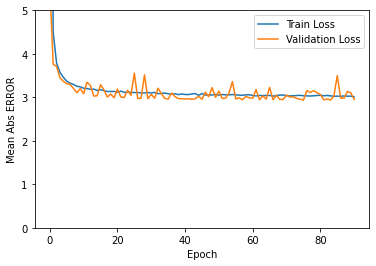

In [85]:
# 画图
def plot_reghistory(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs ERROR')
    plt.plot(history.epoch,np.array(history.history['mae']),label='Train Loss')
    plt.plot(history.epoch,np.array(history.history['val_mae']),label='Validation Loss')
    # plt.plot(history.epoch,np.array(history.history['mse']),label='Train Loss1')
    # plt.plot(history.epoch,np.array(history.history['val_mse']),label='Val loss1')
    plt.legend()
    plt.ylim([0,5])
    plt.show()
 
plot_reghistory(reghistory)

In [86]:
# [loss,mae]=model.evaluate(test_data,test_label,verbose=0)
# print("Testing set Mean Abs Error:${:7.2f}".format(mae*1000))

# 分类
## 使用复杂模型请将complexmodel设为True

In [87]:
# 建模
complexmodel = False
if complexmodel: # 使用多层神经网络
    clfmodel = keras.Sequential([
        keras.layers.Dense(32,activation='relu',input_shape=(38,)),
        # keras.layers.Dense(32,activation='relu'),
        keras.layers.Dense(2,activation='softmax')
    ])
else:
    clfmodel = keras.Sequential([
        keras.layers.Dense(2,activation='softmax',input_shape=(38,))
    ])

clfmodel.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy',km.f1_score()])
clfmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 78        
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


/Users/bryan/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [88]:
# 数据变形
data = x = tf.cast(XY[features], dtype=tf.float32)
labels = tf.squeeze(XY['标签'])
labels = tf.one_hot(labels, depth=2)

In [89]:
# 拟合
clfhistory = clfmodel.fit(data, labels, validation_split=0.2, epochs=6, verbose=0, callbacks=[PrintDot()])
print(clfhistory.history.keys())

/Users/bryan/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '
2021-12-05 05:26:25.461995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2021-12-05 05:26:26.688221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



 0......dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


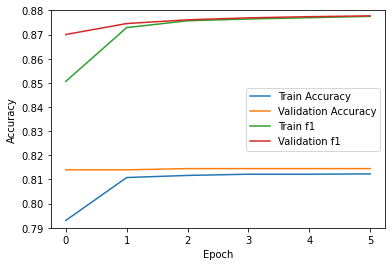

In [90]:
# 绘图
def plot_clfhistory(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch,np.array(history.history['accuracy']),label='Train Accuracy')
    plt.plot(history.epoch,np.array(history.history['val_accuracy']),label='Validation Accuracy')
    plt.plot(history.epoch,np.array(history.history['f1_score']),label='Train f1')
    plt.plot(history.epoch,np.array(history.history['val_f1_score']),label='Validation f1')
    plt.legend()
    plt.ylim([0.79,0.88])
    plt.show()
 
plot_clfhistory(clfhistory)